# Gaussian process model checking: test cases

Here we test model checking diagnostics patterned after Bastos-O'Hagen:

<div>
    Leonardo S. Bastos and Anthony O'Hagan, 
    <a href="https://doi.org/10.1198/TECH.2009.08019"> <i>Diagnostics for Gaussian Process Emulators</i> </a>,
    Technometrics <b>51</b>, 425 (2009).
</div>

The diagnostic functions are from the <a href="https://github.com/jordan-melendez/gsum">gsum module</a> written by Jordan Melendez.

Last revised 10-Dec-2018 by Dick Furnstahl [furnstahl.1@osu.edu], building on the original notebook by Jordan Melendez and modifications by Daniel Phillips. 

## Overview of B&O Model Checking Implementation

Bastos & O'Hagan provide a versatile set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
This notebook tests our adaptations of their methods.

## Modules to import

(rjf note: imports in the original notebook that were moved to gsum have been removed.)

In [1]:
# standard python: see online documentation
import numpy as np
import scipy as sp

# For plotting we use matplotlib; other choices are possible
import matplotlib as mpl
import matplotlib.pyplot as plt

# special imports for python programming: see online documentation
from itertools import cycle

# scikit-learn machine learning  https://scikit-learn.org/stable/modules/classes.html
from sklearn.gaussian_process import GaussianProcessRegressor
   # see https://scikit-learn.org/stable/modules/gaussian_process.html
   #  for documentation. Main excerpt:
   # The GaussianProcessRegressor implements Gaussian processes (GP) for 
   #  regression purposes. For this, the prior of the GP needs to be specified. 
   #  The prior mean is assumed to be constant and zero (for normalize_y=False) 
   #  or the training data’s mean (for normalize_y=True). 
   #  The prior’s covariance is specified by passing a kernel object. 
   #  The hyperparameters of the kernel are optimized during fitting of 
   #  GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) 
   #  based on the passed optimizer. If the initial hyperparameters should be kept 
   #  fixed, None can be passed as optimizer.
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
   # RBF is a particular GP kernel (radial-basis function kernel, aka 
   #  squared-exponential kernel).
   # ConstantKernel: "Can be used as part of a product-kernel where it scales the 
   #  magnitude of the other factor (kernel) or as part of a sum-kernel, where it 
   #  modifies the mean of the Gaussian process."
   # WhiteKernel: "The main use-case of this kernel is as part of a sum-kernel where 
   #  it explains the noise-component of the signal. Tuning its parameter corresponds 
   #  to estimating the noise-level."

# gsum is the package written by Jordan Melendez
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis
from gsum import lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess
from gsum import Diagnostic, GraphicalDiagnostic


In [2]:
# set rcParams here
mpl.rcParams['figure.dpi'] = 120

In [3]:
%matplotlib inline

## Test case 

This test case will generate toy data from the same given GP by sampling a few curves and selecting a set of training points from each curve.  Then we fit a GP to the data. 



### Parameters to adjust

In [4]:
output_directory = './saved_notebooks'
output_filename = 'rjf_model_checking_no_shift_seed_2_samples_4'

# mesh points for the GPs (x_num points from x_min to x_max)
x_min = 0
x_max = 20
x_num = 41
X_full = np.atleast_2d(np.linspace(x_min, x_max, x_num)).T

# toy data points (every data_skip points starting with data_offset point)
data_skip = 5
data_offset = 0   # should be less than data_skip
from math import ceil
data_pts = ceil(x_num/data_skip)
# mask array True entry if corresponding point is in training data, otherwise False 
mask = np.array([(i-data_offset) % data_skip == 0 for i in range(len(X_full))])

n_samples = 4  # draw n_samples curves
n_ref = 1000   # number of diagnostic samples (should this ever change?)

# DP characterization of the GP(s) used to sample the toy data.
#  Specifies hyperparameters (hps) var and length scale for each GP
#basevar = 1.0; varshiftfactor=1; baselengthscale=3; lengthscaleshift=0.3;
#basevar = 1.0; varshiftfactor=2; baselengthscale=3; lengthscaleshift=0;
basevar = 1.0; varshiftfactor = 1.0; baselengthscale = 3; lengthscaleshift = 0;
toy_gp_hps = [ [basevar, baselengthscale], 
               [basevar*varshiftfactor, baselengthscale+lengthscaleshift],
               [basevar/varshiftfactor, baselengthscale-lengthscaleshift] ]
# More generally, use toy_gp_hps = [ [var0, ls0], [var1, ls1], ...]

seed = 2
toy_gp_seeds = seed + np.arange(n_samples)  # array of n_samples values 
# Here specified as ascending integers starting from an initial seed, 
#  but they could be specified by hand or randomized

nugget_sd = 1e-4  # Check if we are sensitive to the value

# Vertical lines (True) or a histogram (False) for the md and kl plots
vlines = True
#vlines = False

Print a table with specs for the samples:

In [5]:
gps_cycle = cycle(np.arange(len(toy_gp_hps)))   # go through gps cyclically 
print('sample #   variance  length scale  seed   color')
for i in range(n_samples):
    gp_index = next(gps_cycle)
    print('  {0:2d}         {1:.2f}        {2:.1f}        {3:2d}'\
          .format(i, toy_gp_hps[gp_index][0], toy_gp_hps[gp_index][1],
                toy_gp_seeds[i]))


sample #   variance  length scale  seed   color
   0         1.00        3.0         2
   1         1.00        3.0         3
   2         1.00        3.0         4
   3         1.00        3.0         5


### Ok, let's roll!

In [6]:
# Set up array of kernels and gps  
# Each kernel is the sum of an RBF kernel scaled by the variance and a noise kernel 
toy_gp_kernel = []
toy_gp = []
for i in range(len(toy_gp_hps)):
    toy_gp_kernel.append( C(toy_gp_hps[i][0], (1e-3, 1e3)) \
                            * RBF(toy_gp_hps[i][1], (1e-2, 1e2)) \
                          + WhiteKernel(nugget_sd**2) )
    toy_gp.append( GaussianProcessRegressor(kernel=toy_gp_kernel[i], optimizer=None) )

# kernel with starting hyperparameters    
base_gp_kernel = C(basevar, (1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2))

Generate full toy data and split into training and test data.

In [7]:
# Sample the gps at all of the X points
toy_data_full = []      # toy data at X_full
toy_data_training = []  # the points used to train
toy_data_test = []      # the remaining points
gps_cycle = cycle(np.arange(len(toy_gp_hps)))   # sample from gps cyclically 
for i in range(n_samples):
    toy_data_full.append( toy_gp[next(gps_cycle)].sample_y(X_full, n_samples=1, 
                                                   random_state=toy_gp_seeds[i]).T )
    toy_data_training.append( toy_data_full[i][:, mask] )
    toy_data_test.append( toy_data_full[i][:, ~mask])
toy_data_full = np.concatenate(toy_data_full)
toy_data_training = np.concatenate(toy_data_training)
toy_data_test = np.concatenate(toy_data_test)
    
X_training = X_full[mask]
X_test = X_full[~mask]


Now we fit the data and compute means and covariances:

In [8]:
my_gp = ConjugateGaussianProcess(base_gp_kernel)
my_gp.fit(X_training, toy_data_training)

# compute the mean and covariance of the fitted GP at the training set points
fitmean = my_gp.mean(X_training)
fitcov = my_gp.cov(X_training)

# compute the values of the fitted GP at all the data points
X_pred = X_full  # should switch to X_test
m_pred, K_pred = my_gp.predict(X_pred, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

# compute the mean and covariance of the overall GP at the set X_full
fitmean_full = my_gp.mean(X_pred)
fitcov_full = my_gp.cov(X_pred,X_pred)


### Plot the toy data and fits

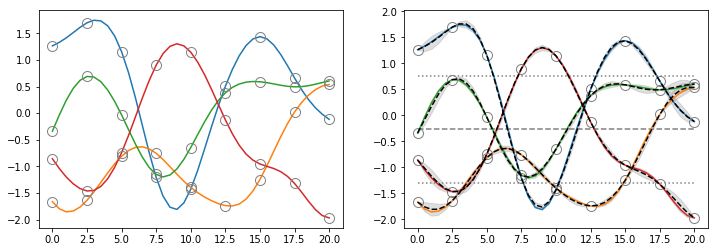

In [9]:
# Plot the gps, test data, and fits
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(X_full.ravel(), toy_data_full.T);
ax1.plot(X_training.ravel(), toy_data_training.T, 
         ls='', marker='o', fillstyle='none', markersize=10, c='gray');


ax2 = fig.add_subplot(1,2,2)
# Plot the underlying process
ax2.plot(X_training.ravel(), my_gp.mean(), ls='--', c='gray')
ax2.plot(X_training.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
ax2.plot(X_training.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
ax2.plot(X_full.ravel(), toy_data_full.T);
ax2.plot(X_training.ravel(), toy_data_training.T, ls='', marker='o', 
         fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
ax2.plot(X_pred.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    ax2.fill_between(X_pred.ravel(), m + 2*sd_pred, m - 2*sd_pred, 
                     color='gray', alpha=0.25)
# ax2.legend();

Comments: 

**\[rjf\] Seed starts at 2 but now with four curves.  Look pretty ordinary.**

We can do better than these "by eye" checks. What does B&O model checking say about this case? First, assume that we are checking the underlying process, shown by the constant gray dotted/dashed lines above, against the colored draws.

### Use the training data only

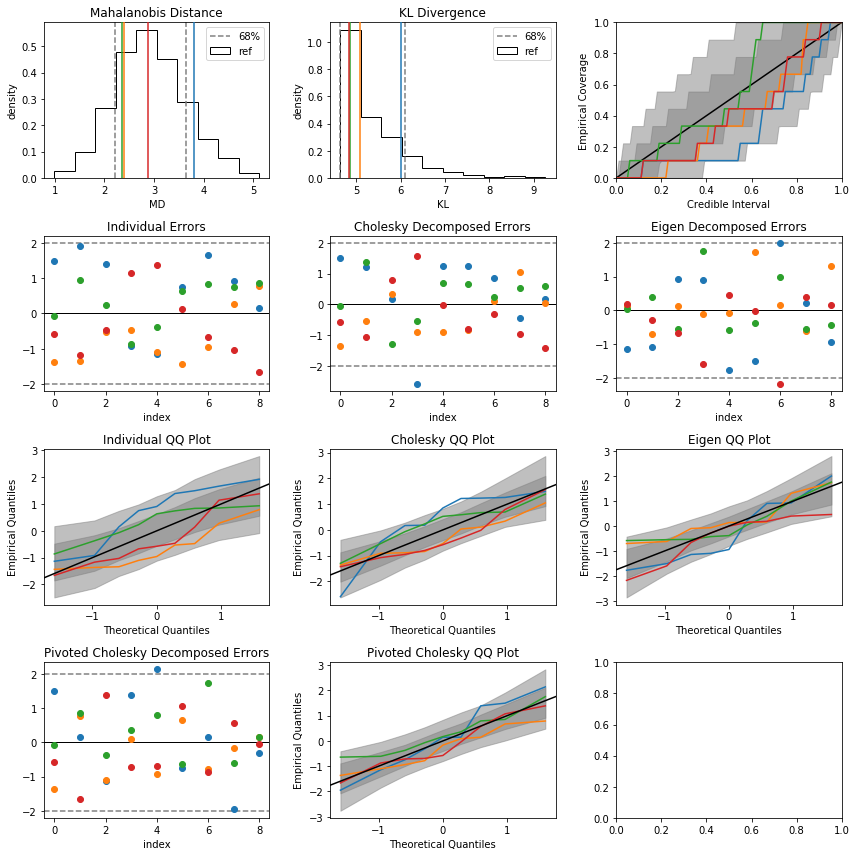

In [10]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(base_gp_kernel)
gpmc = Diagnostic(fitmean, fitcov)
gd = GraphicalDiagnostic(gpmc, toy_data_training, nref=n_ref)
gd.plotzilla(X_training, gp, vlines=vlines);

Comments: 

**\[rjf\] Looks good.**

### Use the full dataset

In [11]:
# At the moment we do this test against the full data set, although we may decide 
#  to remove training data later
toy_data_pred = toy_data_full

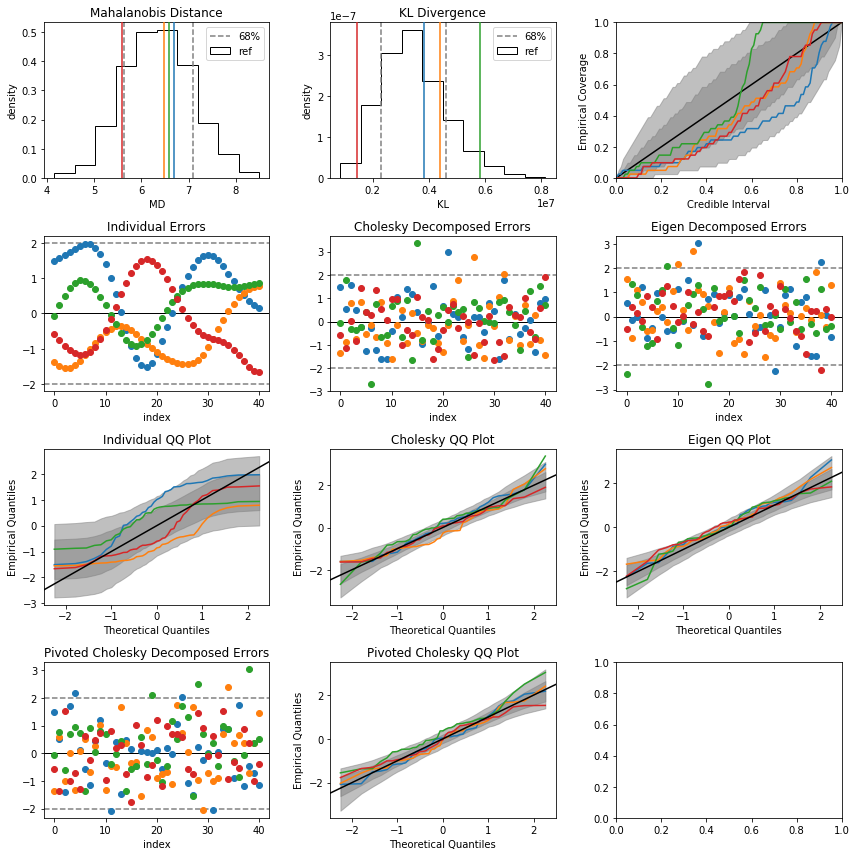

In [12]:
gp = ConjugateGaussianProcess(base_gp_kernel)
gpmc_full = Diagnostic(fitmean_full, 
                       fitcov_full + nugget_sd**2 * np.eye(fitcov_full.shape[0]))
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_pred, nref=n_ref)
gd_full.plotzilla(X_full, gp, vlines=vlines);


Comments: 

**\[rjf\] This looks fine everywhere (except maybe KL divergence).**

### Model checking with the interpolants

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

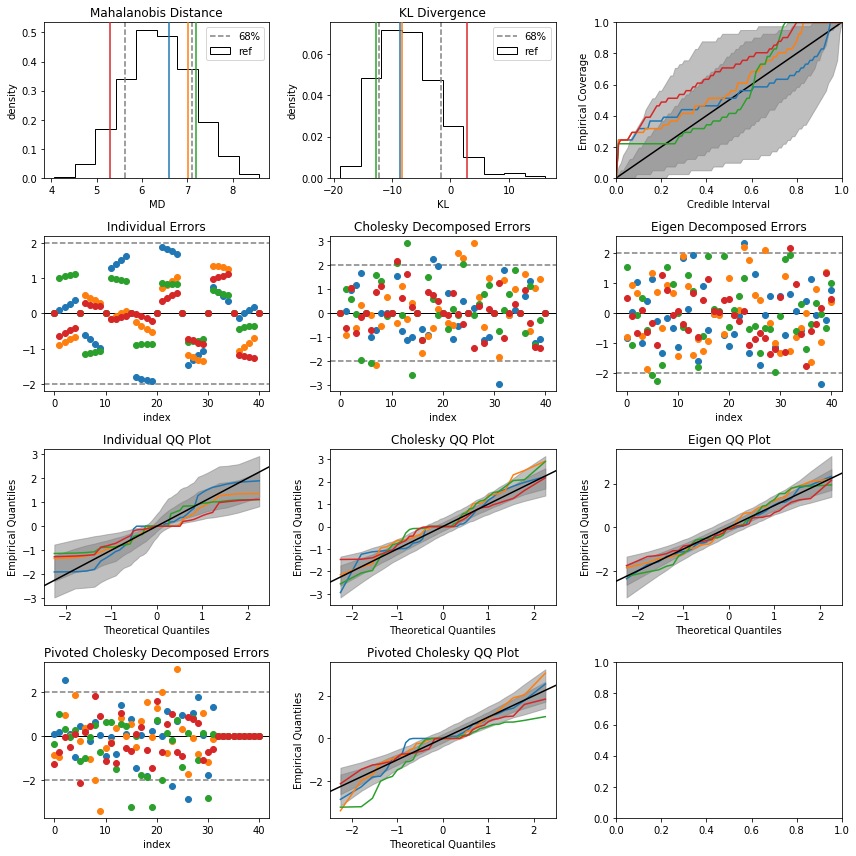

In [13]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(base_gp_kernel, v0=0)
gp.fit(X_training, toy_data_training, noise_sd=nugget_sd)
mean_est, cov_est = gp.predict(X_pred, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(m_pred.shape[1]), K_pred \
                  + nugget_sd**2 * np.eye(K_pred.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_pred - m_pred, nref=n_ref)
gd.plotzilla(X_pred, gp, predict=True, vlines=vlines);

Comments: 

**\[rjf\] Also looks fine (should use test data, though!)**

In [14]:
# *** RUN THIS CELL AFTER YOU HAVE SAVED THE NOTEBOOK ***
# save as a pdf file
!jupyter nbconvert GP_model_checking_test_cases_rjf.ipynb --to pdf \
                  --output-dir=$output_directory --output $output_filename \
                  >/dev/null 2>&1